## Time-Series Classification using PyCaret QDA: Dhaka Tribune

Dataset: Dhaka Tribune 2021 Dataset

Resampling Technique: Daily

Author: Sumaia Parveen Shupti

* Created on: 07/15/2021

* Updated on: 08/08/2021

### Import Libraries

In [1]:
#!pip install pycaret

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from datetime import datetime, timedelta
import warnings
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import f1_score,accuracy_score, precision_score, recall_score, roc_curve, roc_auc_score, precision_recall_curve, auc
from sklearn import metrics
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import plot_precision_recall_curve
from sklearn.metrics import average_precision_score, confusion_matrix
import matplotlib.pyplot as plt

%matplotlib inline
warnings.filterwarnings("ignore")


plt.rcParams['figure.figsize'] = (12, 6)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

### Load Dataset

In [3]:
df = pd.read_csv('../input/dhakatribunecomplete/Dhaka Tribune Complete Data.csv')
df['Accident date'] = pd.to_datetime(df['Accident date'])

df = df[['Accident date', 'Deaths']]
df = df.sort_values(by = 'Accident date')
df = df.reset_index(drop = True).set_index('Accident date').resample('1D').sum()
df = df.reset_index()
df['Deaths'] = df['Deaths'].fillna(0)
print(df.shape)
df.head(12)

(1829, 2)


,Accident date,Deaths
0,2016-06-24,3.0
1,2016-06-25,0.0
2,2016-06-26,0.0
3,2016-06-27,0.0
4,2016-06-28,0.0
5,2016-06-29,0.0
6,2016-06-30,0.0
7,2016-07-01,0.0
8,2016-07-02,0.0
9,2016-07-03,0.0


### Feature Enginnering

In [4]:
df['Accident date'] = pd.to_datetime(df['Accident date'])
df['Year'] = df['Accident date'].dt.year
df['Month'] = df['Accident date'].dt.month
df['Day'] = df['Accident date'].dt.day
df['DayofWeek'] = df['Accident date'].dt.weekday
df['Weekend_(y/n)'] = ((df['Accident date'].dt.dayofweek) // 5 == 1).astype(float)
df['DayofYear'] = df['Accident date'].dt.dayofyear
# Convert the date into a number (of days since some point)
fromDate = min(df['Accident date'])
df['DateInt'] = (df['Accident date'] - fromDate).astype(np.int64)/100000000000
df.head()

,Accident date,Deaths,Year,Month,Day,DayofWeek,Weekend_(y/n),DayofYear,DateInt
0,2016-06-24,3.0,2016,6,24,4,0.0,176,0.0
1,2016-06-25,0.0,2016,6,25,5,1.0,177,864.0
2,2016-06-26,0.0,2016,6,26,6,1.0,178,1728.0
3,2016-06-27,0.0,2016,6,27,0,0.0,179,2592.0
4,2016-06-28,0.0,2016,6,28,1,0.0,180,3456.0


### Binary Classification maybe?

In [5]:
# create a new column and use np.select to assign values to it using our lists as arguments
df['deathYorN'] = np.select([df['Deaths'] > 0], [1])

# display updated DataFrame
df.head(12)

,Accident date,Deaths,Year,Month,Day,DayofWeek,Weekend_(y/n),DayofYear,DateInt,deathYorN
0,2016-06-24,3.0,2016,6,24,4,0.0,176,0.0,1
1,2016-06-25,0.0,2016,6,25,5,1.0,177,864.0,0
2,2016-06-26,0.0,2016,6,26,6,1.0,178,1728.0,0
3,2016-06-27,0.0,2016,6,27,0,0.0,179,2592.0,0
4,2016-06-28,0.0,2016,6,28,1,0.0,180,3456.0,0
5,2016-06-29,0.0,2016,6,29,2,0.0,181,4320.0,0
6,2016-06-30,0.0,2016,6,30,3,0.0,182,5184.0,0
7,2016-07-01,0.0,2016,7,1,4,0.0,183,6048.0,0
8,2016-07-02,0.0,2016,7,2,5,1.0,184,6912.0,0
9,2016-07-03,0.0,2016,7,3,6,1.0,185,7776.0,0


In [6]:
df.dtypes

Accident date    datetime64[ns]
Deaths                  float64
Year                      int64
Month                     int64
Day                       int64
DayofWeek                 int64
Weekend_(y/n)           float64
DayofYear                 int64
DateInt                 float64
deathYorN                 int64
dtype: object

### Feature Corelation

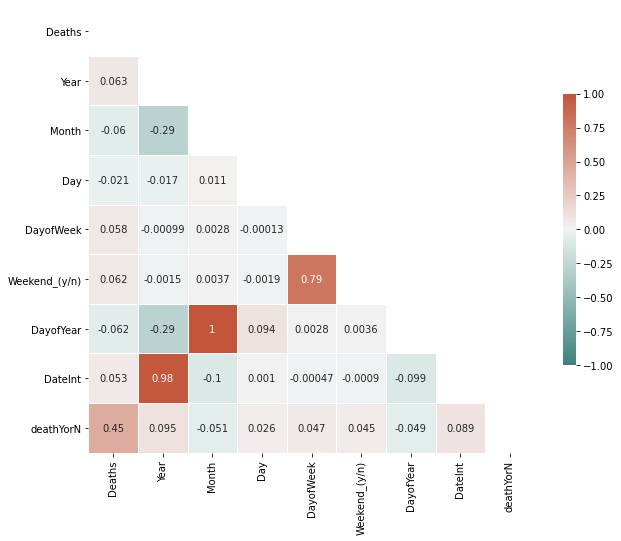

In [7]:
import seaborn as sns

correlation = df.corr()

mask = np.zeros_like(correlation, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

f, ax = plt.subplots(figsize=(10, 10))

cmap = sns.diverging_palette(180, 20, as_cmap=True)
sns.heatmap(correlation, mask=mask, cmap=cmap, vmax=1, vmin =-1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True)

plt.show()

### Train Test Split

In [8]:
start_ = df['Accident date'].max()
end_ = df['Accident date'].min()

test_end = df['Accident date'].max()
test_start = df['Accident date'].max() - timedelta(days = 90)

train_end = test_start - timedelta(days = 1)
train_start = train_end - timedelta(days = 90*8)

print('Dataset Start Date: {}'.format(start_))
print('Dataset End Date: {}'.format(end_))
print (' ')
print('Train Set Start Date: {}'.format(train_start))
print('Train Set End Date: {}'.format(train_end))
print (' ')
print('Test Set Start Date: {}'.format(test_start))
print('Test Set End Date: {}'.format(test_end))
print (' ')

Dataset Start Date: 2021-06-26 00:00:00
Dataset End Date: 2016-06-24 00:00:00
 
Train Set Start Date: 2019-04-07 00:00:00
Train Set End Date: 2021-03-27 00:00:00
 
Test Set Start Date: 2021-03-28 00:00:00
Test Set End Date: 2021-06-26 00:00:00
 


In [9]:
mask = (df['Accident date'] > train_start) & (df['Accident date'] <= train_end)
train = df.loc[mask]
train = train.drop('Accident date', 1)
train = train.drop('Deaths', 1)

mask = (df['Accident date'] > test_start) & (df['Accident date'] <= test_end)
test = df.loc[mask]
test = test.drop('Accident date', 1)
test = test.drop('Deaths', 1)

In [10]:
train.tail()

,Year,Month,Day,DayofWeek,Weekend_(y/n),DayofYear,DateInt,deathYorN
1733,2021,3,23,1,0.0,82,1497312.0,0
1734,2021,3,24,2,0.0,83,1498176.0,0
1735,2021,3,25,3,0.0,84,1499040.0,0
1736,2021,3,26,4,0.0,85,1499904.0,1
1737,2021,3,27,5,1.0,86,1500768.0,0


In [11]:
test.head()

,Year,Month,Day,DayofWeek,Weekend_(y/n),DayofYear,DateInt,deathYorN
1739,2021,3,29,0,0.0,88,1502496.0,0
1740,2021,3,30,1,0.0,89,1503360.0,0
1741,2021,3,31,2,0.0,90,1504224.0,1
1742,2021,4,1,3,0.0,91,1505088.0,0
1743,2021,4,2,4,0.0,92,1505952.0,0


In [12]:
# Train-Test Split
X_train = train.drop('deathYorN', axis = 1) 
y_train = train[['deathYorN']]

X_test = test.drop('deathYorN', axis = 1) 
y_test = test[['deathYorN']]

### Creating Synthetic Samples

In [13]:
# import SMOTE 
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state = 25, sampling_strategy='auto')   # again we are eqalizing both the classes

# fit the sampling
X_train, y_train = sm.fit_resample(X_train, y_train)
np.unique(y_train, return_counts=True)     # Y_train is numpy array, so unique() functions returns the count of all the unique elements in the array

from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

### Count of Classes

<AxesSubplot:xlabel='deathYorN', ylabel='count'>

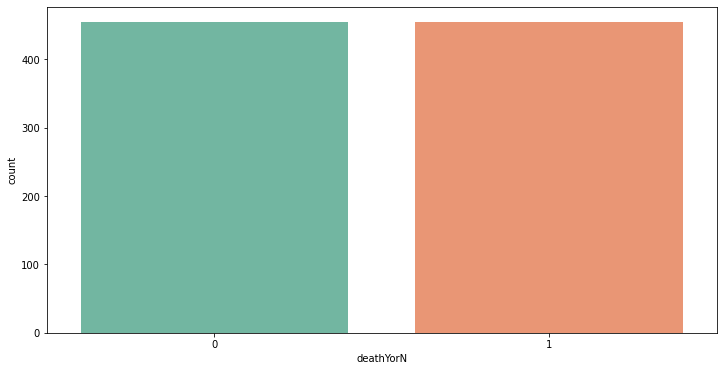

In [14]:
sns.countplot(y_train.deathYorN, palette = "Set2")

### PyCaret Implementation

In [15]:
from pycaret.classification import *
exp_clf101 = setup(data = train, target = 'deathYorN', session_id=123) 

,Description,Value
0,session_id,123
1,Target,deathYorN
2,Target Type,Binary
3,Label Encoded,"0: 0, 1: 1"
4,Original Data,"(720, 8)"
5,Missing Values,False
6,Numeric Features,3
7,Categorical Features,4
8,Ordinal Features,False
9,High Cardinality Features,False


### Comparing the model for Best Recall Score

In [16]:
%%time
best = compare_models(sort = 'Recall')

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
qda,Quadratic Discriminant Analysis,0.5346,0.5359,0.5405,0.3810,0.4369,0.0625,0.0683,0.0100
svm,SVM - Linear Kernel,0.4953,0.0000,0.5000,0.1746,0.2588,0.0000,0.0000,0.0100
dt,Decision Tree Classifier,0.5485,0.5161,0.4046,0.3830,0.3865,0.0348,0.0355,0.0100
et,Extra Trees Classifier,0.5687,0.5492,0.3484,0.3892,0.3632,0.0412,0.0425,0.2690
lda,Linear Discriminant Analysis,0.6362,0.6401,0.3314,0.4878,0.3904,0.1457,0.1528,0.0090
knn,K Neighbors Classifier,0.6123,0.5723,0.3304,0.4282,0.3674,0.0992,0.1010,0.0700
rf,Random Forest Classifier,0.6004,0.5680,0.3304,0.4190,0.3669,0.0819,0.0840,0.3040
ada,Ada Boost Classifier,0.6341,0.5941,0.3206,0.4916,0.3792,0.1378,0.1482,0.0530
lightgbm,Light Gradient Boosting Machine,0.6023,0.5556,0.3193,0.4192,0.3600,0.0803,0.0826,0.1180
catboost,CatBoost Classifier,0.6203,0.5905,0.3144,0.4521,0.3659,0.1097,0.1150,1.0150


CPU times: user 4.57 s, sys: 223 ms, total: 4.8 s
Wall time: 2min 56s


In [17]:
qda = create_model('qda')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.5490,0.4874,0.2778,0.3333,0.3030,-0.0262,-0.0265
1,0.5686,0.5278,0.3889,0.3889,0.3889,0.0556,0.0556
2,0.5882,0.5934,0.6111,0.4400,0.5116,0.1717,0.1786
3,0.6000,0.6114,0.6471,0.4400,0.5238,0.2000,0.2111
4,0.5400,0.5660,0.6471,0.3929,0.4889,0.1140,0.1259
5,0.5400,0.4948,0.3333,0.3529,0.3429,-0.0105,-0.0106
6,0.6400,0.6580,0.7222,0.5000,0.5909,0.2880,0.3036
7,0.4400,0.5260,0.8333,0.3750,0.5172,0.0411,0.0625
8,0.4200,0.4861,0.7222,0.3514,0.4727,-0.0226,-0.0304
9,0.4600,0.4080,0.2222,0.2353,0.2286,-0.1863,-0.1865


### Let's look at the evaluation metric of the un-tuned version first

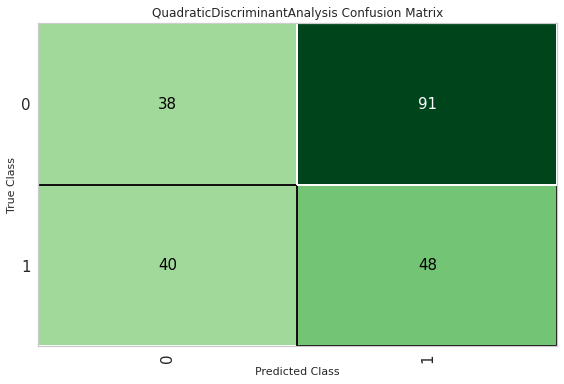

In [18]:
plot_model(qda, plot = 'confusion_matrix')

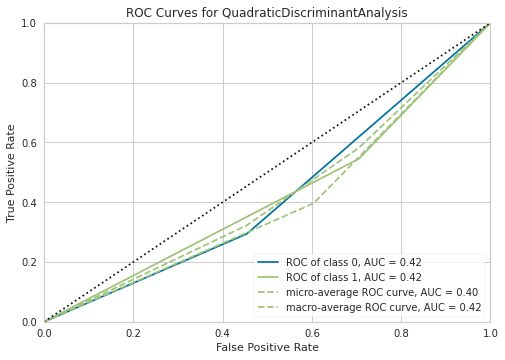

In [19]:
plot_model(qda, plot = 'auc')

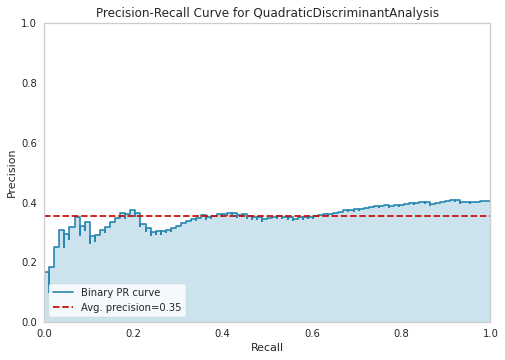

In [20]:
plot_model(qda, plot = 'pr')

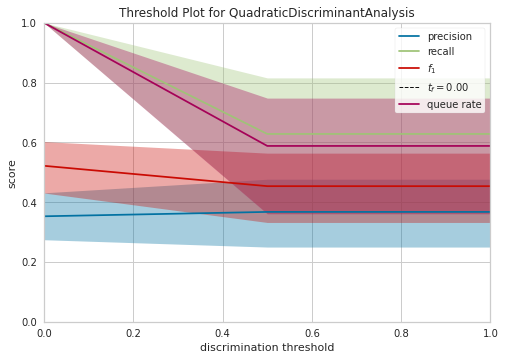

In [21]:
plot_model(qda, plot = 'threshold')

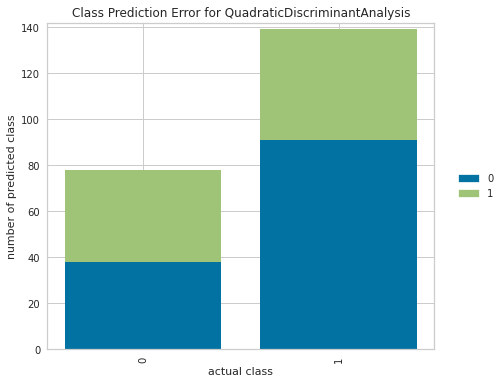

In [22]:
plot_model(qda, plot = 'error')

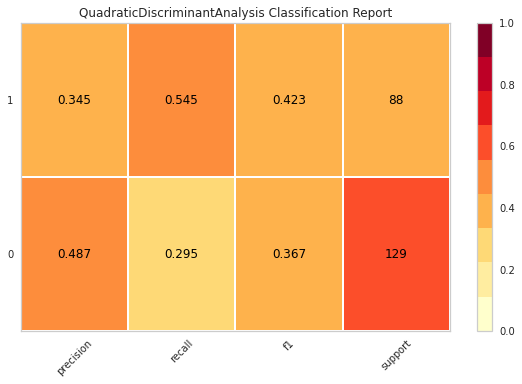

In [23]:
plot_model(qda, plot = 'class_report')

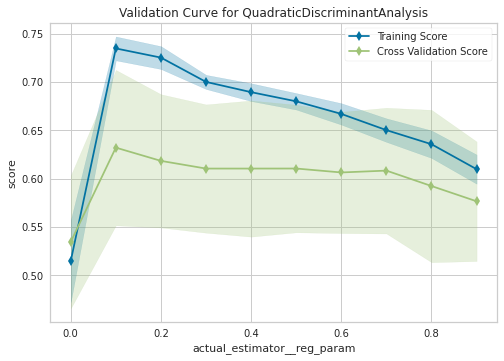

In [24]:
plot_model(qda, plot = 'vc')

In [25]:
plot_model(qda, plot = 'parameter')

,Parameters
priors,None
reg_param,0.0
store_covariance,False
tol,0.0001


In [26]:
predict_model(qda);
print(qda)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Quadratic Discriminant Analysis,0.3963,0.4200,0.5455,0.3453,0.4229,-0.1465,-0.1637


QuadraticDiscriminantAnalysis(priors=None, reg_param=0.0,
                              store_covariance=False, tol=0.0001)


In [27]:
unseen_predictions = predict_model(qda, data=test)
unseen_predictions["Date"] = df['Accident date'][1739:]
unseen_predictions = unseen_predictions.set_index('Date')
unseen_predictions

,Year,Month,Day,DayofWeek,Weekend_(y/n),DayofYear,DateInt,deathYorN,Label,Score
Date,,,,,,,,,,
2021-03-29,2021,3,29,0,0.0,88,1502496.0,0,0,1.0
2021-03-30,2021,3,30,1,0.0,89,1503360.0,0,1,1.0
2021-03-31,2021,3,31,2,0.0,90,1504224.0,1,1,1.0
2021-04-01,2021,4,1,3,0.0,91,1505088.0,0,0,1.0
2021-04-02,2021,4,2,4,0.0,92,1505952.0,0,0,1.0
...,...,...,...,...,...,...,...,...,...,...
2021-06-22,2021,6,22,1,0.0,173,1575936.0,0,1,1.0
2021-06-23,2021,6,23,2,0.0,174,1576800.0,1,0,1.0
2021-06-24,2021,6,24,3,0.0,175,1577664.0,0,0,1.0


In [28]:
actuals = unseen_predictions.deathYorN
prediction = unseen_predictions.Label

act = actuals.to_frame().reset_index()
pred = prediction.to_frame().reset_index()

In [29]:
import plotly.graph_objects as go
import pandas as pd


fig = go.Figure(data=go.Scatter(x=act['Date'],
                                        y=act['deathYorN'],
                                        mode='lines+markers',
                                        marker=dict(
                                            size=12,
                                            color='LightSkyBlue'),
                                        text=act['deathYorN'], opacity = 0.9)) # hover text goes here

fig.update_layout(title='Actual Death Data: 2021/03/29 to 2021/06/26',  xaxis=dict(showgrid=False, title="Date"), yaxis=dict(showgrid=False, title="Death?"))
fig.show()

fig = go.Figure(data=go.Scatter(x=pred['Date'],
                                        y=pred['Label'],
                                        mode='lines+markers',
                                        marker=dict(
                                            size=12,
                                            color='MediumSeaGreen'),
                                        text=pred['Label'], opacity = 0.9)) # hover text goes here

fig.update_layout(title='Predicted Results: 2021/03/29 to 2021/06/26', xaxis=dict(showgrid=False, title="Date"), yaxis=dict(showgrid=False, title="Death?"))
fig.show()

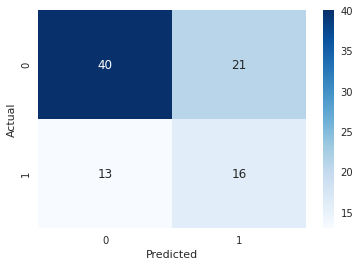

True Positives: 16, False Positives: 21, True Negatives: 40, False Negatives: 13


In [30]:
data = confusion_matrix(actuals, prediction)
df_cm = pd.DataFrame(data, columns=np.unique(y_test), index = np.unique(y_test))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (6, 4))
sns.heatmap(df_cm, cmap="Blues", annot=True,annot_kws={"size": 12})# font size
plt.show()
        
tn, fp, fn, tp = confusion_matrix(actuals, prediction).ravel()
print ("True Positives: {}, False Positives: {}, True Negatives: {}, False Negatives: {}".format(tp, fp, tn, fn))

### Let's tune the model for best recall score and re-visit the evluation metrics

In [31]:
tuned_qda = tune_model(qda, optimize = 'Recall')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.5490,0.6406,0.7222,0.4194,0.5306,0.1518,0.1730
1,0.5098,0.7003,0.8333,0.4054,0.5455,0.1344,0.1785
2,0.5490,0.5522,0.6111,0.4074,0.4889,0.1134,0.1209
3,0.6400,0.6301,0.5294,0.4737,0.5000,0.2201,0.2209
4,0.4000,0.4216,0.5294,0.2903,0.3750,-0.1144,-0.1340
5,0.5400,0.6267,0.5000,0.3913,0.4390,0.0589,0.0602
6,0.6800,0.7743,0.8333,0.5357,0.6522,0.3808,0.4130
7,0.5400,0.5781,0.5556,0.4000,0.4651,0.0800,0.0833
8,0.5000,0.6571,0.5556,0.3704,0.4444,0.0219,0.0234
9,0.6200,0.7083,0.7778,0.4828,0.5957,0.2726,0.3005


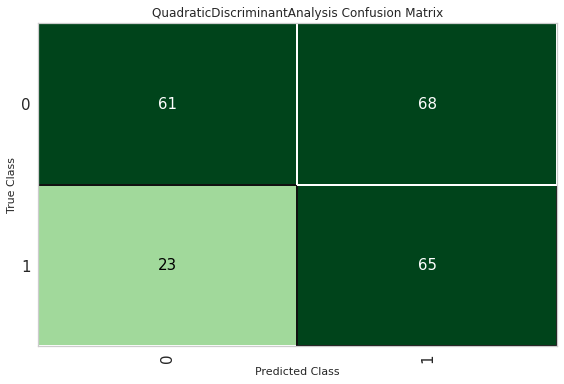

In [32]:
plot_model(tuned_qda, plot = 'confusion_matrix')

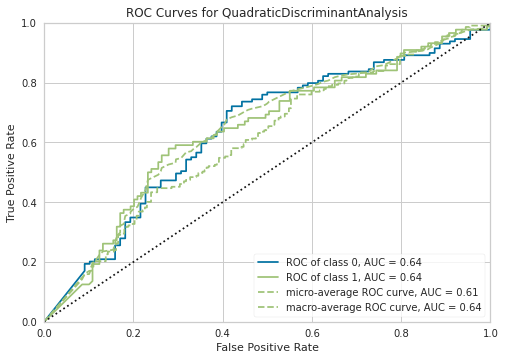

In [33]:
plot_model(tuned_qda, plot = 'auc')

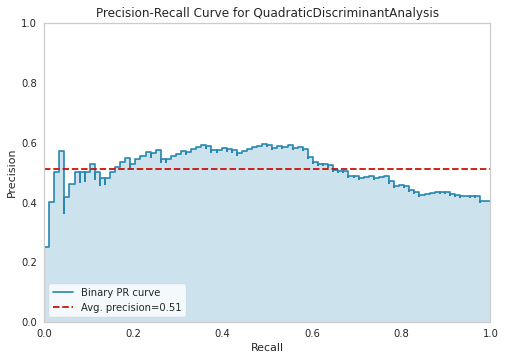

In [34]:
plot_model(tuned_qda, plot = 'pr')

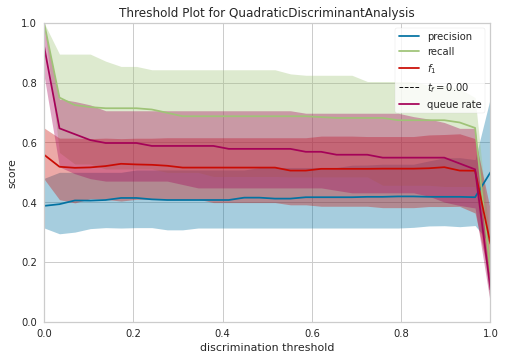

In [35]:
plot_model(tuned_qda, plot = 'threshold')

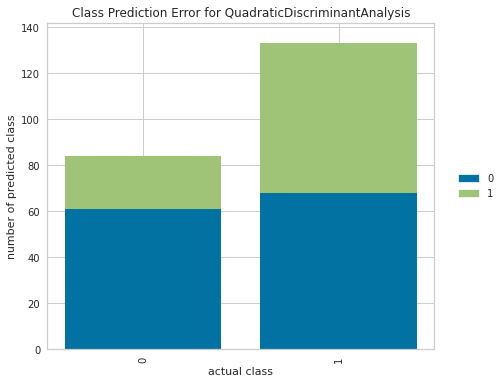

In [36]:
plot_model(tuned_qda, plot = 'error')

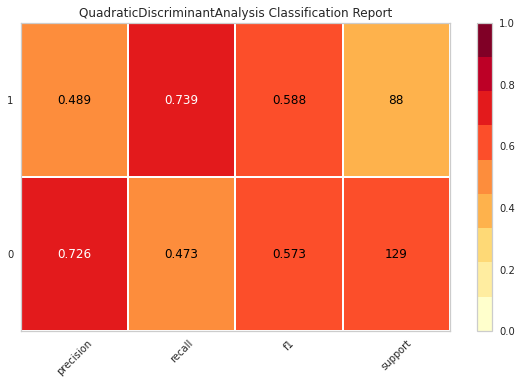

In [37]:
plot_model(tuned_qda, plot = 'class_report')

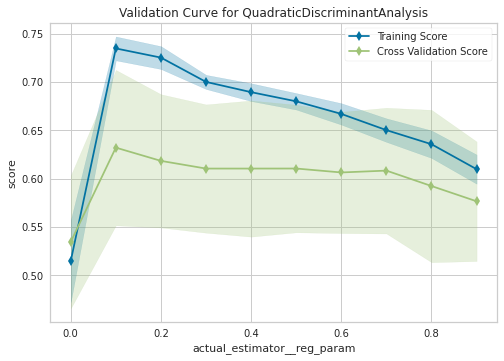

In [38]:
plot_model(tuned_qda, plot = 'vc')

In [39]:
plot_model(tuned_qda, plot = 'parameter')

,Parameters
priors,None
reg_param,0.98
store_covariance,False
tol,0.0001


In [40]:
predict_model(tuned_qda);
print(tuned_qda)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Quadratic Discriminant Analysis,0.5806,0.6403,0.7386,0.4887,0.5882,0.1956,0.2132


QuadraticDiscriminantAnalysis(priors=None, reg_param=0.98,
                              store_covariance=False, tol=0.0001)


#### We will work with the un-tuned QDA model.

### **Prediction on Unseen Data**

In [41]:
unseen_predictions = predict_model(tuned_qda, data=test)
unseen_predictions["Date"] = df['Accident date'][1739:]
unseen_predictions = unseen_predictions.set_index('Date')
unseen_predictions

,Year,Month,Day,DayofWeek,Weekend_(y/n),DayofYear,DateInt,deathYorN,Label,Score
Date,,,,,,,,,,
2021-03-29,2021,3,29,0,0.0,88,1502496.0,0,0,1.0000
2021-03-30,2021,3,30,1,0.0,89,1503360.0,0,0,1.0000
2021-03-31,2021,3,31,2,0.0,90,1504224.0,1,0,1.0000
2021-04-01,2021,4,1,3,0.0,91,1505088.0,0,1,0.6729
2021-04-02,2021,4,2,4,0.0,92,1505952.0,0,1,0.5023
...,...,...,...,...,...,...,...,...,...,...
2021-06-22,2021,6,22,1,0.0,173,1575936.0,0,0,1.0000
2021-06-23,2021,6,23,2,0.0,174,1576800.0,1,0,1.0000
2021-06-24,2021,6,24,3,0.0,175,1577664.0,0,0,1.0000


### Viz of Actual vs Prediction

In [42]:
actuals = unseen_predictions.deathYorN
prediction = unseen_predictions.Label

act = actuals.to_frame().reset_index()
pred = prediction.to_frame().reset_index()

In [43]:
import plotly.graph_objects as go
import pandas as pd


fig = go.Figure(data=go.Scatter(x=act['Date'],
                                        y=act['deathYorN'],
                                        mode='lines+markers',
                                        marker=dict(
                                            size=12,
                                            color='LightSkyBlue'),
                                        text=act['deathYorN'], opacity = 0.9)) # hover text goes here

fig.update_layout(title='Actual Death Data: 2021/03/29 to 2021/06/26',  xaxis=dict(showgrid=False, title="Date"), yaxis=dict(showgrid=False, title="Death?"))
fig.show()

fig = go.Figure(data=go.Scatter(x=pred['Date'],
                                        y=pred['Label'],
                                        mode='lines+markers',
                                        marker=dict(
                                            size=12,
                                            color='MediumSeaGreen'),
                                        text=pred['Label'], opacity = 0.9)) # hover text goes here

fig.update_layout(title='Predicted Results: 2021/03/29 to 2021/06/26', xaxis=dict(showgrid=False, title="Date"), yaxis=dict(showgrid=False, title="Death?"))
fig.show()

### Unseen Data: Confusion Matrix

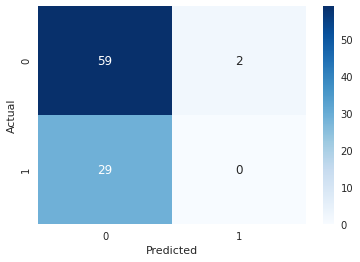

True Positives: 0, False Positives: 2, True Negatives: 59, False Negatives: 29


In [44]:
data = confusion_matrix(actuals, prediction)
df_cm = pd.DataFrame(data, columns=np.unique(y_test), index = np.unique(y_test))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (6, 4))
sns.heatmap(df_cm, cmap="Blues", annot=True,annot_kws={"size": 12})# font size
plt.show()
        
tn, fp, fn, tp = confusion_matrix(actuals, prediction).ravel()
print ("True Positives: {}, False Positives: {}, True Negatives: {}, False Negatives: {}".format(tp, fp, tn, fn))

### We choose to work with the un-tuned QDA model

In [45]:
unseen_predictions = predict_model(qda, data=test)
unseen_predictions["Date"] = df['Accident date'][1739:]
unseen_predictions = unseen_predictions.set_index('Date')

actuals = unseen_predictions.deathYorN
prediction = unseen_predictions.Label

### Recall, Precision & F1 Score

In [46]:
def macro_weighted_prec_rec(y_test, y_hat):
    
    acc_test = metrics.accuracy_score(y_test, y_hat)
    print ("Accuracy Score of Test Set:", round(acc_test, 4))
    
    print('.')
    
    rec_mic = metrics.recall_score(y_test, y_hat, average = 'micro')
    print ("Micro Average Recall Score:", round(rec_mic, 4))

    rec_mac = metrics.recall_score(y_test, y_hat, average = 'macro')
    print ("Macro Average of Recall Score:", round(rec_mac, 4))

    rec_wei = metrics.recall_score(y_test, y_hat, average = 'weighted')
    print ("Weighted Average of Recall Score:", round(rec_wei, 4))
    
    print ('.')
    
    prec_mic = metrics.precision_score(y_test, y_hat, average = 'micro')
    print ("Micro Average Precision Score:", round(prec_mic))
    
    prec_mac = metrics.precision_score(y_test, y_hat, average = 'macro')
    print ("Macro Average of Precision Score:", round(prec_mac, 4))

    prec_wei = metrics.precision_score(y_test, y_hat, average = 'weighted')
    print ("Weighted Average of Precision Score:", round(prec_wei, 4))
    
    print ('.')
    
    f1_mic = metrics.f1_score(y_test, y_hat, average = 'micro')
    print ("Micro Average of F1 Score:", round(f1_mic, 4))

    f1_mac = metrics.f1_score(y_test, y_hat, average = 'macro')
    print ("Macro Average of F1 Score:", round(f1_mac, 4))

    f1_wei = metrics.f1_score(y_test, y_hat, average = 'weighted')
    print ("Weighted Average of F1 Score:", round(f1_wei, 4))

In [47]:
macro_weighted_prec_rec(actuals, prediction)

Accuracy Score of Test Set: 0.6222
.
Micro Average Recall Score: 0.6222
Macro Average of Recall Score: 0.6037
Weighted Average of Recall Score: 0.6222
.
Micro Average Precision Score: 1
Macro Average of Precision Score: 0.5936
Weighted Average of Precision Score: 0.6509
.
Micro Average of F1 Score: 0.6222
Macro Average of F1 Score: 0.5933
Weighted Average of F1 Score: 0.6319


### Distribution Plot of the Unseen Data

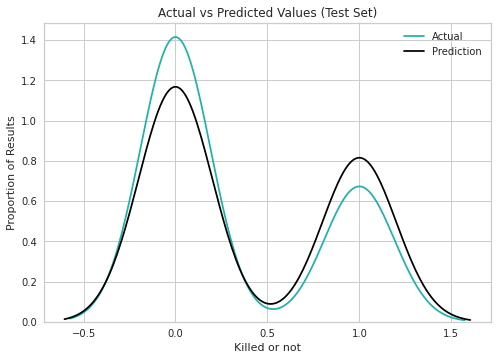

In [48]:
ax2 = sns.distplot(actuals, hist=False, color='lightseagreen', label = 'Actual')
sns.distplot(prediction, hist=False, ax=ax2, color='black', label = 'Prediction')
plt.title('Actual vs Predicted Values (Test Set)')
plt.xlabel('Killed or not')
plt.ylabel('Proportion of Results')
plt.legend()
plt.show()

### References

*  [True vs. False and Positive vs. Negative](https://developers.google.com/machine-learning/crash-course/classification/true-false-positive-negative)
*  [Accuracy](https://developers.google.com/machine-learning/crash-course/classification/accuracy)
*  [Precision and Recall](https://developers.google.com/machine-learning/crash-course/classification/precision-and-recall)
*  [ROC-AUC](https://developers.google.com/machine-learning/crash-course/classification/roc-and-auc)
*  [Relationship between Precision-Recall and ROC Curves](https://www.biostat.wisc.edu/~page/rocpr.pdf)

* https://colab.research.google.com/drive/1GqQ3XAIzg4krBbnOpKyeRqT0qBQhdwYL#scrollTo=nwaZk6oTEQsi